Using 4k vocab is fairly small - should not be getting single characters

White space tokens are strange

We seem have >4k lines in the print out

Look at pretraining and how vocabulary is set up

In [134]:
import re
from aochildes.dataset import AOChildesDataSet
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import words
from datasets import load_dataset
import time

from transformers import PreTrainedTokenizerFast

In [135]:
fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file="baby_bert_tokenizer/tokenizer.json")

In [142]:
fast_tokenizer.encode('hello world ostentatious branjdkf.')

'hell o world o st ent at i ous br an j d k f.'

In [2]:
nltk.download('words')

ds = AOChildesDataSet()

transcripts = ds.load_transcripts()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\dpechi\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Looking for transcripts in C:\Users\dpechi\Documents\AOCHILDES\aochildes\original_transcripts
Utterances before dropping rows: 1,379,962
Utterances after  dropping rows: 1,180,889
Preparing AOCHILDES transcripts...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


In [48]:
vocab_freq = pd.read_csv('AOChildes_word_frequency2.csv')

# words_set = set(words.words())
vocab_set = set(vocab_freq['word'])

## GLUE

In [55]:
for n,sentence in enumerate(sentences):
#             if n%100 == 0:
#                 print(time.ctime())
#                 print(f"{round(100*n/float(denom),2)}% Complete")
    new_sentence = sentence.split(' ')
    new_sentence = [re.sub('[!,@#$?;.\'"]', '', w.lower()) for w in new_sentence]
    print(new_sentence)

['pccw', 's', 'chief', 'operating', 'officer', '', 'mike', 'butcher', '', 'and', 'alex', 'arena', '', 'the', 'chief', 'financial', 'officer', '', 'will', 'report', 'directly', 'to', 'mr', 'so', '']
['the', 'world', 's', 'two', 'largest', 'automakers', 'said', 'their', 'us', 'sales', 'declined', 'more', 'than', 'predicted', 'last', 'month', 'as', 'a', 'late', 'summer', 'sales', 'frenzy', 'caused', 'more', 'of', 'an', 'industry', 'backlash', 'than', 'expected', '']
['according', 'to', 'the', 'federal', 'centers', 'for', 'disease', 'control', 'and', 'prevention', '(', 'news', '-', 'web', 'sites', ')', '', 'there', 'were', '19', 'reported', 'cases', 'of', 'measles', 'in', 'the', 'united', 'states', 'in', '2002', '']
['a', 'tropical', 'storm', 'rapidly', 'developed', 'in', 'the', 'gulf', 'of', 'mexico', 'sunday', 'and', 'was', 'expected', 'to', 'hit', 'somewhere', 'along', 'the', 'texas', 'or', 'louisiana', 'coasts', 'by', 'monday', 'night', '']
['the', 'company', 'didn', 't', 'detail', 'th

['the', '2', '1', '/', '2', '-ton', 'probe', 'will', 'plunge', 'into', 'the', 'thick', 'jovian', 'atmosphere', 'today', 'at', '3', ':', '49', 'pm', 'eastern', 'time', '', 'disintegrating', 'moments', 'later', 'from', 'the', 'friction', 'generated', 'by', 'its', '108000-mph', 'free-fall', '']
['sen', 'michael', 'crapo', '', 'r-idaho', '', 'chairman', 'of', 'the', 'subcommittee', 'that', 'will', 'consider', 'the', 'nomination', '', 'is', 'a', 'longtime', 'friend', '']
['if', 'senator', 'clinton', 'does', 'decide', 'to', 'run', 'in', '2008', '', 'she', 'cannot', 'announce', 'her', 'candidacy', 'before', '2006', '', 'which', 'is', 'when', 'she', 'faces', 're-election', 'for', 'the', 'senate', '']
['people', 'who', 'have', 'opposed', 'these', 'actions', 'throughout', 'are', 'now', 'trying', 'to', 'find', 'fresh', 'reasons', 'to', 'say', 'this', 'wasn', 't', 'the', 'right', 'thing', 'to', 'do', '', '']
['intel', 'sells', 'the', 'current', 'top', 'pentium', 'for', 'us', '', '637', 'in', 'quan

In [130]:
subsets = ['cola', 'sst2', 'mrpc', 'qqp', 'stsb', 'mnli', 'mnli_mismatched', 'mnli_matched', 'qnli', 'rte', 'wnli', 'ax']
# subsets = ['cola']
graph_data = []
inclusivity_check = []
for subset in subsets:
    dataset = load_dataset('glue',subset)
    print(dataset)
    
    inclusivity_check_ds = []
    
    for segment in dataset.keys():
        print(segment)
        if 'sentence' in dataset[segment].features:
            sentences = dataset[segment]['sentence']
        
        else:
            t1 = list(dataset[segment].features)[0]
            t2 = list(dataset[segment].features)[1]
            sentences = [' '.join(i) for i in zip(dataset[segment][t1], dataset[segment][t2])]
        denom = len(sentences)

        for n,sentence in enumerate(sentences):
#             if n%100 == 0:
#                 print(time.ctime())
#                 print(f"{round(100*n/float(denom),2)}% Complete")
            new_sentence = sentence.split(' ')
            #removing proper nouns helps with MRPC
            contractions = set(['nt','s','re','t','d','ll'])
            new_sentence = [w for n,w in enumerate(new_sentence) if (w == w.lower() or n==0)]
            new_sentence = [re.sub('[0-9!:&“”—\-_,@#$?;’.\'\(\)"]', '', w.lower()) for w in new_sentence]
            new_sentence = [w for w in new_sentence if w != '' and w not in contractions]
            sentence_inclusion = []
            for word in new_sentence:
                if word not in vocab_set:
                    inclusive_word = 0
                else:
                    inclusive_word = 1
                sentence_inclusion.append(inclusive_word)
            inclusivity_check_ds.append(sentence_inclusion)
            inclusivity_check.append([subset, sentence_inclusion])
    
    complete_sentences = 0
    missing_1 = 0
    most_included = 0
    n_ex = len(inclusivity_check_ds)
    for sentence in inclusivity_check_ds:
        if len(sentence) == sum(sentence):
            complete_sentences +=1
        if len(sentence) == sum(sentence)+1:
            missing_1 +=1
        if len(sentence) <= sum(sentence)*1.25:
            most_included +=1
    print(subset)
    complete_sentences_c = complete_sentences/n_ex
    print(complete_sentences_c)
    missing_1_c = (complete_sentences+missing_1)/n_ex
    print(missing_1_c)
    most_included_c = most_included/n_ex
    graph_data.append([subset,complete_sentences_c,missing_1_c,most_included_c])

                #if it's a new word, add it, print the new words


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\cola\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})
train
validation
test
cola
0.6186544055550343
0.9234306089893967


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})
train
validation
test
sst2
0.3123411667285343
0.632106450415465


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\mrpc\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})
train
validation
test
mrpc
0.10170660230994656
0.22099637993449406


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\qqp\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 363846
    })
    validation: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 390965
    })
})
train
validation
test
qqp
0.32749820494667653
0.5391837191492893


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\stsb\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 5749
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1379
    })
})
train
validation
test
stsb
0.40148354195642094
0.5921418636995828


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})
train
validation_matched
validation_mismatched
test_matched
test_mismatched
mnli
0.24817126243078574
0.43796644382303374


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\mnli_mismatched\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})
validation
test
mnli_mismatched
0.25387468875450986
0.41877127902840594


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\mnli_matched\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
})
validation
test
mnli_matched
0.2525113456733466
0.444750395186375


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\qnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 104743
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
    test: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
})
train
validation
test
qnli
0.09316238577319766
0.27335759797352793


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\rte\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3000
    })
})
train
validation
test
rte
0.06346453962198717
0.17773539101786023


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\wnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 635
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 71
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 146
    })
})
train
validation
test
wnli
0.41784037558685444
0.653755868544601


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\ax\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 1104
    })
})
test
ax
0.24456521739130435
0.36141304347826086


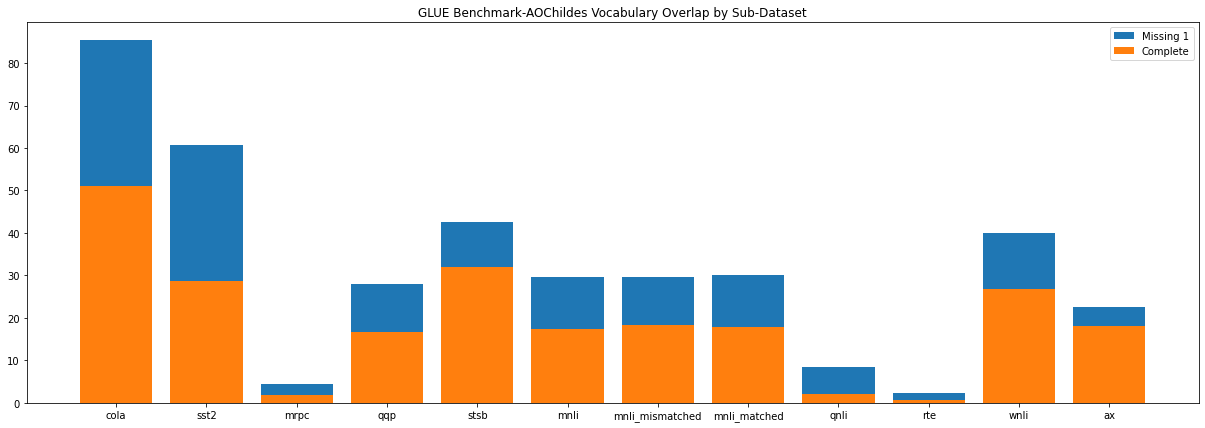

In [100]:
plt.figure(figsize=(21,7))
plt.title("GLUE Benchmark-AOChildes Vocabulary Overlap (with Proper Nouns) by Sub-Dataset")
plt.bar([ds[0] for ds in graph_data],[100*ds[2] for ds in graph_data],label='1 Token Missing')
plt.bar([ds[0] for ds in graph_data],[100*ds[1] for ds in graph_data],label='Complete')

plt.legend()
plt.show()

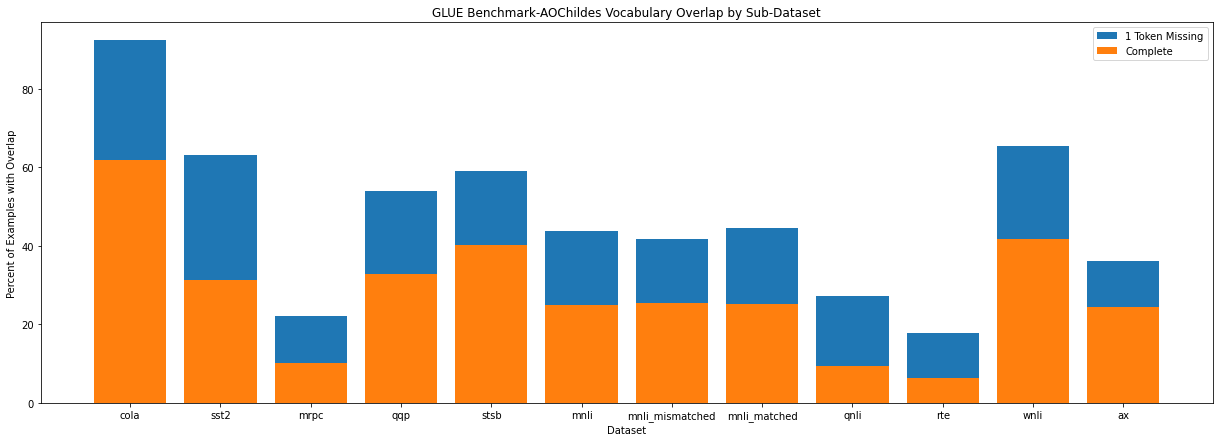

In [126]:
plt.figure(figsize=(21,7))
plt.title("GLUE Benchmark-AOChildes Vocabulary Overlap by Sub-Dataset")
plt.bar([ds[0] for ds in graph_data],[100*ds[2] for ds in graph_data],label='1 Token Missing')
plt.bar([ds[0] for ds in graph_data],[100*ds[1] for ds in graph_data],label='Complete')
plt.xlabel('Dataset')
plt.ylabel('Percent of Examples with Overlap')

plt.legend()
plt.show()

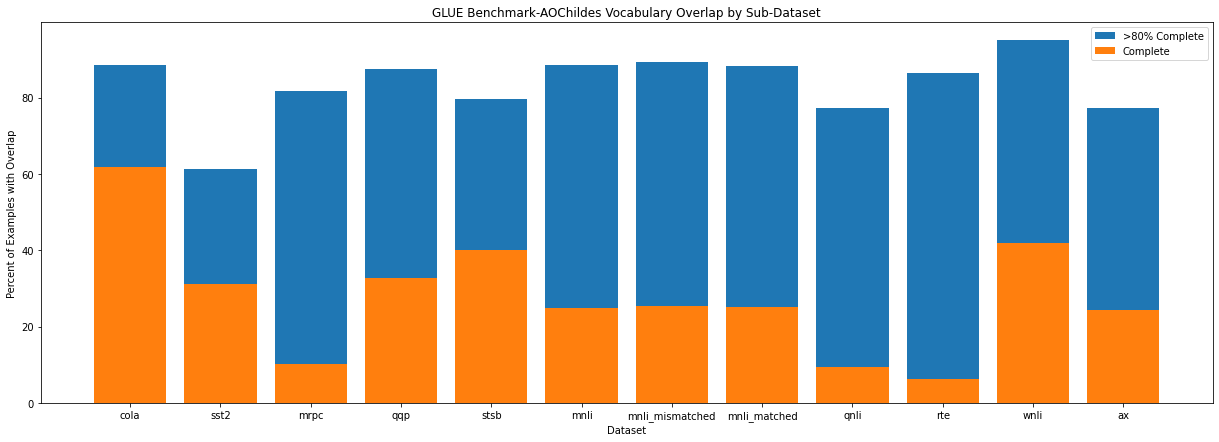

In [131]:
plt.figure(figsize=(21,7))
plt.title("GLUE Benchmark-AOChildes Vocabulary Overlap by Sub-Dataset")
plt.bar([ds[0] for ds in graph_data],[100*ds[3] for ds in graph_data],label='>80% Complete')
plt.bar([ds[0] for ds in graph_data],[100*ds[1] for ds in graph_data],label='Complete')
plt.xlabel('Dataset')
plt.ylabel('Percent of Examples with Overlap')

plt.legend()
plt.show()

In [129]:
for sentence in inclusivity_check:
    if sentence[0] == 'mrpc':
        print(sentence)

['mrpc', [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]]
['mrpc', [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1]]
['mrpc', [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]]
['mrpc', 

['mrpc', [1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]]
['mrpc', [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,

['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]]
['mrpc', [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1]]
['mrpc', [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]]
['mrpc', [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]]
['mrpc', [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]]
['mrpc', [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]]
['mrpc', [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0]]
['mrpc', [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 

['mrpc', [1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]]
['mrpc', [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]]
['mrpc', [1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]]
['mrpc', [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 

['mrpc', [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]]
['mrpc', [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [127]:
#why is MRPC coverage so low?
mrpc = load_dataset('glue','mrpc')
sentences = mrpc['train']['sentence1']
contractions = set(['nt','s','re','t','d','ll'])
for n,sentence in enumerate(sentences):
    new_sentence = sentence.split(' ')
    new_sentence = [w for n,w in enumerate(new_sentence) if (w == w.lower() or n==0)]
    new_sentence = [re.sub('[0-9!:&“”—\-_,@#$?;’.\'\(\)"]', '', w.lower()) for w in new_sentence]
    new_sentence = [w for w in new_sentence if w != '' and w not in contractions]
    print(new_sentence)

Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\mrpc\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

['amrozi', 'accused', 'his', 'brother', 'whom', 'he', 'called', 'the', 'witness', 'of', 'deliberately', 'distorting', 'his', 'evidence']
['yucaipa', 'owned', 'before', 'selling', 'the', 'chain', 'to', 'in', 'for', 'billion']
['they', 'had', 'published', 'an', 'advertisement', 'on', 'the', 'on', 'offering', 'the', 'cargo', 'for', 'sale', 'he', 'added']
['around', 'shares', 'were', 'up', 'cents', 'or', '%', 'at', 'having', 'earlier', 'set', 'a', 'record', 'high', 'of']
['the', 'stock', 'rose', 'or', 'about', 'percent', 'to', 'close', 'at', 'on', 'the']
['revenue', 'in', 'the', 'first', 'quarter', 'of', 'the', 'year', 'dropped', 'percent', 'from', 'the', 'same', 'period', 'a', 'year', 'earlier']
['the', 'had', 'a', 'weekly', 'gain', 'of', 'or', 'percent', 'closing', 'at', 'on']
['the', 'then', 'appealed', 'to', 'the', 'state']
['that', 'compared', 'with', 'million', 'or', 'cents', 'per', 'share', 'in', 'the', 'yearago', 'period']
['shares', 'of', 'a', 'much', 'larger', 'company', 'with', 

['mr', 'had', 'been', 'living', 'in', 'a', 'protective', 'custody', 'unit', 'since', 'being', 'transferred', 'to', 'the', 'prison', 'on']
['winfs', 'will', 'require', 'that', 'applications', 'be', 'rewritten', 'to', 'exploit', 'such', 'capabilities']
['the', 'pilot', 'decided', 'to', 'fly', 'to', 'which', 'has', 'longer', 'runways', 'than']
['the', 'number', 'of', 'probable', 'cases', 'dropped', 'to', 'on', 'from', 'on', 'in', 'and', 'around', 'a', 'city', 'of', 'four', 'million', 'people']
['despite', 'their', 'differences', 'and', 'leaders', 'said', 'there', 'were', 'areas', 'of', 'agreement']
['bolland', 'told', 'the', 'of', 'the', 'was', 'astonished', 'at', 'question']
['symbol', 'former', 'chief', 'accounting', 'officer', 'is', 'expected', 'to', 'plead', 'guilty', 'in', 'a', 'federal', 'court', 'in', 'later', 'according', 'to', 'reports']
['two', 'partners', 'in', 'business', 'were', 'arrested', 'last', 'week', 'and', 'questioned', 'by', 'magistrates', 'investigating', 'the', 'col

['the', 'said', 'there', 'was', 'a', 'clear', 'risk', 'of', 'terrorist', 'attack', 'in', 'and']
['the', 'fell', 'or', 'about', 'percent', 'to']
['the', 'truck', 'carried', 'the', 'equivalent', 'of', 'tons', 'of', 'emergency', 'ministry', 'official', 'said']
['an', 'international', 'warrant', 'for', 'his', 'arrest', 'was', 'issued', 'both', 'to', 'the', 'authorities', 'and', 'to']
['peoplesoft', 'board', 'of', 'directors', 'on', 'unanimously', 'rejected', 'revised', 'bid', 'of', 'per', 'share']
['luzerne', 'told', 'a', 'news', 'conference', 'that', 'authorities', 'were', '``continuing', 'to', 'make', 'significant', 'progress', 'in', 'the', 'case']
['berry', 'also', 'married', 'and', 'divorced', 'his', 'second', 'wife', 'twice', 'most', 'recently', 'in']
['goldman', 'also', 'raised', 'its', 'quarterly', 'dividend', 'to', 'cents', 'from', 'cents', 'citing', 'the', 'new', 'tax', 'law']
['tomorrow', 'testimony', 'is', 'to', 'give', 'an', 'inside', 'look', 'at', 'tax', 'shelter', 'developmen

In [6]:
import time
vocab_dict = {}
bad_words = []
for segment in ['train','validation','test']:
    print(segment)
    sentences = dataset[segment]['sentence']
    denom = len(sentences)
    
    for n,sentence in enumerate(sentences):
        if n%100 == 0:
            print(time.ctime())
            print(f"{round(100*n/float(denom),2)}% Complete")
        new_sentence = sentence.split(' ')
        new_sentence = [re.sub('[!,@#$?;.\'"]', '', w.lower()) for w in new_sentence]
        for word in new_sentence:
            #if it's a new word, add it, print the new words
            if word not in vocab_dict and word in words.words():

                vocab_dict[word] = 1
            
            else:
                if word not in words.words():
                    if word not in bad_words:
                        bad_words.append(word)
                else:
                    vocab_dict[word] += 1


train
Thu Oct 20 22:51:48 2022
0.0% Complete
Thu Oct 20 22:53:17 2022
1.17% Complete
Thu Oct 20 22:55:59 2022
2.34% Complete
Thu Oct 20 22:58:48 2022
3.51% Complete
Thu Oct 20 23:00:24 2022
4.68% Complete
Thu Oct 20 23:01:57 2022
5.85% Complete
Thu Oct 20 23:03:19 2022
7.02% Complete
Thu Oct 20 23:04:51 2022
8.19% Complete
Thu Oct 20 23:06:12 2022
9.36% Complete
Thu Oct 20 23:08:03 2022
10.53% Complete
Thu Oct 20 23:09:54 2022
11.69% Complete
Thu Oct 20 23:11:35 2022
12.86% Complete
Thu Oct 20 23:13:29 2022
14.03% Complete
Thu Oct 20 23:15:30 2022
15.2% Complete
Thu Oct 20 23:17:50 2022
16.37% Complete
Thu Oct 20 23:20:02 2022
17.54% Complete
Thu Oct 20 23:22:01 2022
18.71% Complete
Thu Oct 20 23:24:03 2022
19.88% Complete
Thu Oct 20 23:26:54 2022
21.05% Complete
Thu Oct 20 23:28:48 2022
22.22% Complete
Thu Oct 20 23:30:41 2022
23.39% Complete
Thu Oct 20 23:32:15 2022
24.56% Complete
Thu Oct 20 23:34:51 2022
25.73% Complete
Thu Oct 20 23:37:41 2022
26.9% Complete
Thu Oct 20 23:40:46 20

In [39]:
import time
inclusivity_check = []
vocab_set = set(vocab_freq['word'])
for segment in ['train','validation','test']:
    print(segment)
    sentences = dataset[segment]['sentence']
    denom = len(sentences)
    
    for n,sentence in enumerate(sentences):
        if n%100 == 0:
            print(time.ctime())
            print(f"{round(100*n/float(denom),2)}% Complete")
        new_sentence = sentence.split(' ')
        new_sentence = [re.sub('[!,@#$?;.\'"]', '', w.lower()) for w in new_sentence]
        
        sentence_inclusion = []
        for word in new_sentence:
            if word not in vocab_set:
                inclusive_word = 0
            else:
                inclusive_word = 1
            sentence_inclusion.append(inclusive_word)
        inclusivity_check.append(sentence_inclusion)
            
            
            #if it's a new word, add it, print the new words
            

train
Fri Oct 21 11:39:50 2022
0.0% Complete
Fri Oct 21 11:39:50 2022
1.17% Complete
Fri Oct 21 11:39:50 2022
2.34% Complete
Fri Oct 21 11:39:50 2022
3.51% Complete
Fri Oct 21 11:39:50 2022
4.68% Complete
Fri Oct 21 11:39:50 2022
5.85% Complete
Fri Oct 21 11:39:50 2022
7.02% Complete
Fri Oct 21 11:39:50 2022
8.19% Complete
Fri Oct 21 11:39:50 2022
9.36% Complete
Fri Oct 21 11:39:50 2022
10.53% Complete
Fri Oct 21 11:39:51 2022
11.69% Complete
Fri Oct 21 11:39:51 2022
12.86% Complete
Fri Oct 21 11:39:51 2022
14.03% Complete
Fri Oct 21 11:39:51 2022
15.2% Complete
Fri Oct 21 11:39:51 2022
16.37% Complete
Fri Oct 21 11:39:51 2022
17.54% Complete
Fri Oct 21 11:39:51 2022
18.71% Complete
Fri Oct 21 11:39:51 2022
19.88% Complete
Fri Oct 21 11:39:51 2022
21.05% Complete
Fri Oct 21 11:39:51 2022
22.22% Complete
Fri Oct 21 11:39:51 2022
23.39% Complete
Fri Oct 21 11:39:51 2022
24.56% Complete
Fri Oct 21 11:39:51 2022
25.73% Complete
Fri Oct 21 11:39:51 2022
26.9% Complete
Fri Oct 21 11:39:51 20

In [44]:
complete_sentences = 0
missing_1 = 0
for sentence in inclusivity_check:
    if len(sentence) == sum(sentence):
        complete_sentences +=1
    if len(sentence) == sum(sentence)+1:
        missing_1 +=1
print(complete_sentences/len(inclusivity_check))
print((complete_sentences+missing_1)/len(inclusivity_check))

0.5050201745331707
0.8470488880547996


In [ ]:
# Compute percentage of examples that only contain words in our vocabulary

In [32]:
bad_words_df = pd.DataFrame(bad_words)

In [38]:
vocab_freq[vocab_freq['word']=='mom']

,Unnamed: 0,word,frequency


In [36]:
n=0
vocab_set = set(vocab_freq['word'])
for w in bad_words:
    if w not in vocab_set:
        print(w)
        n+=1

murkier
herman
critics
5
sd
sf
john
waltzes
urinated
vanished
ron
aliza
ok
poorer
geniuses
inclined
susan
janet
became
succumbed
lobbyists
succumbs
youll
couldnt
louise
isnt
survived
hasnt
paid
marianne
``

heard
lynn
kathy
elected
children
mickey
women
gary
criticizes
subjects
emitted
ions
contained
resulted
grades
occupies
inhabits
straddles
straddled
avoided
agents
concluded
fond
wimp
regards
politicians
harriet
vivien
virginia
manuscripts
succeeded
flo
miami
play-offs
french
recited
fools
proud
resembles
resembled
10
lb
max
impresses
proclaimed
authorities
criticized
alleged
wagered
enemys
josé
caspar
lilly
recounted
reviewed
josés
questioned
betsy
wildwood
patrons
oscar
hadnt
dulles
angleton
truman
babel
meryl
harris
lesbians
gays
governments
david
gorbachev
rome
carthage
romes
europe
1492
mercury
tourists
guinevere
filed
attended
seminars
physicists
lucie
revised
dld
prescribes
tom
india
attributed
dismissed
dartmouth
60
utah
prisoners
divulged
friday
saturday
awful:
phineas
maxi

In [22]:
n=0
vocab_set = set(vocab_freq['word'])
for w in vocab_dict:
    if w not in vocab_set:
        print(w)
        n+=1

pub
stupor
vanishing
thereby
zigzagged
correspondingly
obnoxious
worded
succumb
corruption
corrupt
corporate
headquarters
suspected
weatherman
astronomy
meteorology
inadequate
unlikely
probable
murderer
uneducated
undisciplined
attentive
diligent
linguist
strived
improve
electrode
circuit
terrorist
parcel
litigation
petrol
widow
donated
valuable
intimately
pompous
conclusively
threadbare
doubtful
abroad
desired
detest
refusing
horrific
refusal
bartender
neuroses
spouse
dickens
barcelona
harassment
autonomous
dogged
infidelity
informal
perception
oneself
moral
impeccable
readable
philosopher
producer
inherit
seminar
godsend
garish
biography
lettering
acquainted
dill
proposal
costly
defendant
stoutly
rutherford
squander
recursive
semantics
generative
preposterous
myron
lute
hefty
whisky
fiat
yearn
luscious
executed
reheat
peruse
deed
forgery
invariably
funds
employee
employer
geezer
carelessly
objection
simultaneously
honorable
polynomial
lemma
politics
blackjack
dislike
true
mao
catastr

In [28]:
print(f"Percent Missing: {100*round(n/len(vocab_dict.keys()),4)}%")
#561 of 3731

Percent Missing: 15.09%


In [32]:
import random

rnd = ['Maggie','Lisa','Tyler','Dan','Matthew','Will','Surendra','Paulina','Nick','Miles']
exceptions = ['Matthew']

rnd_filt = [cool_person for cool_person in rnd if cool_person not in exceptions]
random.shuffle(rnd_filt)
rnd_filt
for cool_person in rnd_filt[:5]:
    print(f"@{cool_person}")

@Lisa
@Dan
@Paulina
@Tyler
@Maggie
